# Modelling
In this notebook, I am going to fit a Machine Learning model on the data to predict whether a person earns more than 50k a year.

I chose R because it will be easier for me to integrate this model inside a user-interface later with Rshiny. But R is less powerful and more limited in ML models than Python. 

In [7]:
library(dplyr)
library(randomForest)
library(rfUtilities)
options(repr.plot.width = 7, repr.plot.height = 5, warn = FALSE)

In [2]:
## Import the data
col_names <- c('age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
               'race','sex','capital-gain','capital-loss','hours-per-week','native-country','class')

train <- read.csv('../data/adult.data', col.names = col_names, strip.white = TRUE)
train[train == '?'] <- NA
train <- train[!is.na(train), ]

test <- read.csv('../data/adult.test', col.names = col_names, strip.white = TRUE, skip = 1)
test[test == '?'] <- NA

In [3]:
df$fnlwgt <- NULL; df$education.num <- NULL

## Function to transform data 
#  - Group categories together
#  - Impute missing data
#
#  Input: a dataframe with all the columns I need (most likely from another function)
##
transform <- function(df, impute_file = 'utils/impute.rda') {
    load(impute_file)
    
    df$age[is.na(df$age)] <- impute['age']
    df$capital.gain[is.na(df$capital.gain)] <- impute['capital.gain']
    df$capital.loss[is.na(df$capital.loss)] <- impute['capital.loss']
    df$hours.per.week[is.na(df$hours.per.week)] <- impute['hours.per.week']
    df$sex[is.na(df$sex)] <- impute['sex']
    
    # workclass
    df$workclass <- as.character(df$workclass)
    df$workclass[df$workclass %in% c('Never-worked','Without-pay')] <- 'Unemployed'
    df$workclass[is.na(df$workclass)] <- impute['workclass']
    df$workclass <- factor(df$workclass)

    # education
    df$education <- factor(df$education, ordered = TRUE, levels = c('Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college','Assoc-acdm','Assoc-voc','Bachelors','Masters','Prof-school','Doctorate'))
    df$educ <- df$education < '5th-6th';              df$educ <- df$educ + (df$education < '10th')
    df$educ <- df$educ + (df$education < 'HS-grad');  df$educ <- df$educ + (df$education < 'Assoc-acdm')
    df$educ <- df$educ + (df$education < 'Bachelors');df$educ <- df$educ + (df$education < 'Masters')
    df$educ <- factor(df$educ + (df$education < 'Prof-school'), levels = c(7,6,5,4,3,2,1,0))
    df$educ[is.na(df$educ)] <- impute['educ']
    levels(df$educ) <- c('before-4th','5th-9th', '10th-12th','HS-grad','Assoc','Bachelors','Masters','Doc-prof'); train$education <- NULL

    # marital status
    df$marital.status <- as.character(df$marital.status)
    df$marital.status[df$marital.status %in% c('Married-AF-spouse','Married-civ-spouse')] <- 'Married'
    df$marital.status[df$marital.status %in% c('Married-spouse-absent','Widowed')] <- 'Widowed-Spouse-absent'
    df$marital.status[is.na(df$marital.status)] <- impute['marital.status']
    df$marital.status <- factor(df$marital.status)

    # occupation
    df$occupation <- as.character(df$occupation)
    df$occupation[df$occupation %in% c('Priv-house-serv','Other-service')] <- 'Other-service'
    df$occupation[df$occupation %in% c('Armed-Forces','Farming-fishing','Machine-op-inspct')] <- 'Other-occupation'
    df$occupation[df$occupation %in% c('Sales','Tech-support')] <- 'Office-service'
    df$occupation[is.na(df$occupation)] <- impute['occupation']
    df$occupation <- factor(df$occupation)

    # relationship
    df$relationship <- as.character(df$relationship)
    df$relationship[df$relationship %in% c('Other-relative','Own-child')] <- 'With-relative'
    df$relationship[df$relationship %in% c('Not-in-family','Unmarried')] <- 'Not-in-family'
    df$relationship[df$relationship %in% c('Husband','Wife')] <- 'Married'
    df$relationship[is.na(df$relationship)] <- impute['relationship']
    df$relationship <- factor(df$relationship)

    # native country
    df$native.country <- as.character(df$native.country)
    df$native.country[df$native.country %in% c('United-States','Canada','Outlying-US(Guam-USVI-etc)')] <- 'north-america'
    df$native.country[df$native.country %in% c('Cuba','Puerto-Rico','Dominican-Republic','Haiti','Jamaica')] <- 'carribean'
    df$native.country[df$native.country %in% c('Honduras','Guatemala','Nicaragua','El-Salvador','Trinadad&Tobago','Peru','Columbia','Ecuador')] <- 'south-america'
    df$native.country[df$native.country %in% c('England','Holand-Netherlands','Ireland','Hungary','Greece','Scotland','Germany','Yugoslavia','Poland','Portugal','France','Italy')] <- 'europe'
    df$native.country[df$native.country %in% c('China','Hong','Japan','Philippines','India','Vietnam','Cambodia','Thailand','South','Iran','Laos','Taiwan')] <- 'asia'
    df$native.country[is.na(df$native.country)] <- impute['native.country']
    df$native.country <- factor(df$native.country)

    # Race
    df$race[is.na(df$race)] <- impute['race']
    df$race <- factor(df$race, levels = c('White','Asian-Pac-Islander','Black','Amer-Indian-Eskimo','Other'))
    
    return(df)
}

In [4]:
## To re-balanced the data
train <- train %>% rbind(train[train$class == '>50K', ])

In [5]:
## Fit a Random Forest
rf <- randomForest(class ~ ., data = train, ntree = 80, block.size = 1, importance = T, na.action = na.omit)

# Save the model
save(rf, file = 'utils/model.rda')

In [10]:
## Cross-validation
rf.cv <- rf.crossValidation(rf, train, p = 0.10, n = 10, ntree = 80)

# Plot cross validation verses model producers accuracy
par(mfrow=c(1,2)) 
plot(rf.cv, type = "cv", main = "CV producers accuracy")
plot(rf.cv, type = "model", main = "Model producers accuracy")

# Plot cross validation verses model oob
par(mfrow=c(1,2)) 
plot(rf.cv, type = "cv", stat = "oob", main = "CV oob error")
plot(rf.cv, type = "model", stat = "oob", main = "Model oob error")

running: classification cross-validation with 10 iterations 


ERROR: Error in randomForest.default(y = as.factor(my), x = mx, ytest = as.factor(ty), : length of response must be the same as predictors


,<=50K,>50K,MeanDecreaseAccuracy,MeanDecreaseGini
age,3.832522e-03,0.13461597,0.05586483,2016.0975
workclass,8.345931e-03,0.03771992,0.02003896,506.6531
marital.status,3.893366e-02,0.11001336,0.06719258,1814.9797
occupation,1.986179e-02,0.11678967,0.05842530,1362.9871
relationship,3.933761e-02,0.13334998,0.07673293,2211.8179
race,7.156163e-05,0.01532087,0.00613885,217.1019
sex,8.725495e-03,0.02775621,0.01630310,268.8319
capital.gain,4.667784e-02,0.05299325,0.04919256,1554.0412
capital.loss,7.036938e-03,0.02330877,0.01351144,485.2590
hours.per.week,3.724833e-03,0.08265743,0.03512721,1077.0019


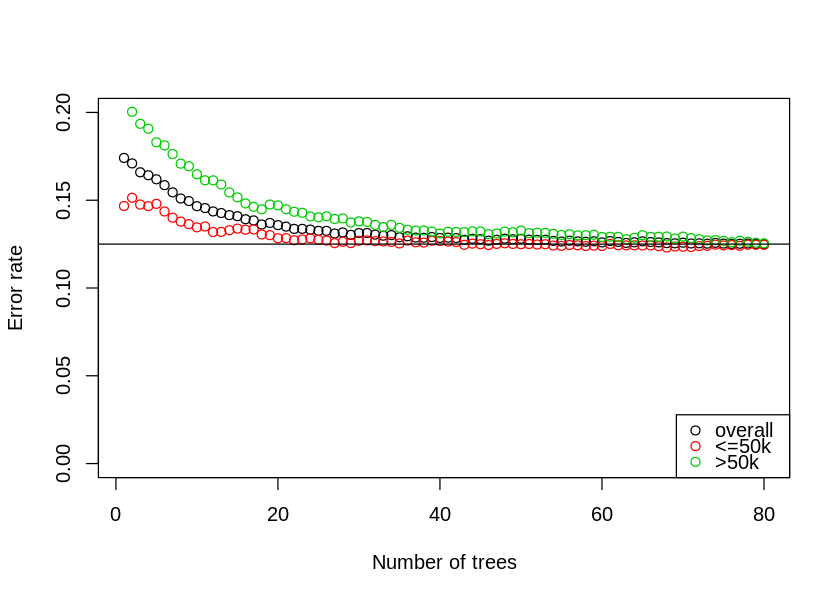

In [79]:
rf$importance

matplot(rf$err.rate, type = c("b"), pch = 1, col = 1:3, ylim = c(0, .2),
        xlab = 'Number of trees', ylab = 'Error rate')
abline(h = .125)
legend('bottomright', legend = c('overall', '<=50k', '>50k'), col = 1:3, pch = 1)

In [41]:
rf.pred <- predict(rf, test)

ERROR: Error in predict.randomForest(rf, test): New factor levels not present in the training data
